# DCGANs (Deep Convolutional Generative Adversarial Networks)

## Initialization

In [1]:
# Install required libraries
!pip install -q torch_snippets torch_summary

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.8/79.8 kB 887.1 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 5.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 204.2/204.2 kB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.9/3.9 MB 19.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 37.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.9/98.9 kB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 54.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.8/30.8 MB 15.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 177.4/177.4 kB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 29.7 MB/s eta 0:

In [2]:
# Import libraries
import numpy as np
import pandas as pd

import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.utils import make_grid
from torchsummary import summary
from torch_snippets import *

import cv2
from PIL import Image

print(f"PyTorch Version: {torch.__version__}")
!nvidia-smi # check if GPU is available
%matplotlib inline

PyTorch Version: 2.2.1+cu121

Wed Apr  3 22:35:29 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P8               9W /  70W |      3MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [3]:
# Set device to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Running on:", device)

Running on: cuda

In [4]:
# Download and extract the dataset
!wget https://www.dropbox.com/s/rbajpdlh7efkdo1/male_female_face_images.zip
!unzip -q male_female_face_images.zip

--2024-04-03 22:35:29--  https://www.dropbox.com/s/rbajpdlh7efkdo1/male_female_face_images.zip
Resolving www.dropbox.com (www.dropbox.com)... 162.125.71.18, 2620:100:6021:18::a27d:4112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.71.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/rbajpdlh7efkdo1/male_female_face_images.zip [following]
--2024-04-03 22:35:30--  https://www.dropbox.com/s/raw/rbajpdlh7efkdo1/male_female_face_images.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uca1822edf89186ccd14365612f1.dl.dropboxusercontent.com/cd/0/inline/CQXFqKSCGeFe7IhTjn1RyQr2RZHZ5yN7tMeH3fHIQPfJitJcq7lalTad_8TWhsQ8dxisKtKCR-ke-VFXNqssZ-HgykD-DwfYMQBV24Bc0pPDja84hD5t_RRFxefldik3-uzGqCja-CjkK7HVZBiV7UhZ/file# [following]
--2024-04-03 22:35:31--  https://uca1822edf89186ccd14365612f1.dl.dropboxusercontent.com/cd/0/inline/CQXFqKSCGeFe7IhTjn1RyQr2RZHZ5yN7tMeH3fHIQPfJitJcq7lalT

In [5]:
# Initialize the face detector from OpenCV
face_cascade = cv2.CascadeClassifier(f'{cv2.data.haarcascades}haarcascade_frontalface_default.xml')

# Create a directory to store the cropped faces
!mkdir cropped_faces
images = Glob('/content/females/*.jpg') + Glob('/content/males/*.jpg')
for i in range(len(images)):
    image = read(images[i], 1)
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray_image, 1.3, 5)
    for (x, y, w, h) in faces:
        cropped_image = image[y:(y+h), x:(x+w), :]
    cv2.imwrite(f'cropped_faces/{str(i)}.jpg', cv2.cvtColor(cropped_image, cv2.COLOR_RGB2BGR))

In [6]:
# Set up a transform pipeline for the images (resize, center crop, to tensor, normalize)
transform = transforms.Compose(
    [
        transforms.Resize(64),
        transforms.CenterCrop(64),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

In [7]:
# Create Dataset class to fetch images and labels
class Faces(Dataset):
    def __init__(self, folder):
        super().__init__()
        self.folder = folder
        self.images = sorted(Glob(folder))

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image_path = self.images[idx]
        image = Image.open(image_path)
        image = transform(image)
        return image

In [9]:
# Create the train dataset
train_ds = Faces(folder='cropped_faces/')

# Create a function to retrieve the dataloaders
def load_data(batch_size = 64):
    return DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=8)

In [10]:
# Create a function to initialize weights so they have less spread
def weights_init(model):
    classname = model.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(model.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(model.weight.data, 1.0, 0.02)
        nn.init.constant_(model.bias.data, 0)

In [11]:
# Create a class for the Discriminator model
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 64, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 64*2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64*2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64*2, 64*4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64*4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64*4, 64*8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64*8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64*8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )
        self.apply(weights_init)

    def forward(self, x):
        return self.model(x)

In [12]:
# Create a mock-up Discriminator model and print summary
discriminator = Discriminator().to(device)
summary(discriminator, torch.zeros(1, 3, 64, 64))

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 1, 1, 1]             --
|    └─Conv2d: 2-1                       [-1, 64, 32, 32]          3,072
|    └─LeakyReLU: 2-2                    [-1, 64, 32, 32]          --
|    └─Conv2d: 2-3                       [-1, 128, 16, 16]         131,072
|    └─BatchNorm2d: 2-4                  [-1, 128, 16, 16]         256
|    └─LeakyReLU: 2-5                    [-1, 128, 16, 16]         --
|    └─Conv2d: 2-6                       [-1, 256, 8, 8]           524,288
|    └─BatchNorm2d: 2-7                  [-1, 256, 8, 8]           512
|    └─LeakyReLU: 2-8                    [-1, 256, 8, 8]           --
|    └─Conv2d: 2-9                       [-1, 512, 4, 4]           2,097,152
|    └─BatchNorm2d: 2-10                 [-1, 512, 4, 4]           1,024
|    └─LeakyReLU: 2-11                   [-1, 512, 4, 4]           --
|    └─Conv2d: 2-12                      [-1, 1, 1, 1]      

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 1, 1, 1]             --
|    └─Conv2d: 2-1                       [-1, 64, 32, 32]          3,072
|    └─LeakyReLU: 2-2                    [-1, 64, 32, 32]          --
|    └─Conv2d: 2-3                       [-1, 128, 16, 16]         131,072
|    └─BatchNorm2d: 2-4                  [-1, 128, 16, 16]         256
|    └─LeakyReLU: 2-5                    [-1, 128, 16, 16]         --
|    └─Conv2d: 2-6                       [-1, 256, 8, 8]           524,288
|    └─BatchNorm2d: 2-7                  [-1, 256, 8, 8]           512
|    └─LeakyReLU: 2-8                    [-1, 256, 8, 8]           --
|    └─Conv2d: 2-9                       [-1, 512, 4, 4]           2,097,152
|    └─BatchNorm2d: 2-10                 [-1, 512, 4, 4]           1,024
|    └─LeakyReLU: 2-11                   [-1, 512, 4, 4]           --
|    └─Conv2d: 2-12                      [-1, 1, 1, 1]      

In [13]:
# Create a class for the Generator model
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.ConvTranspose2d(100, 64*8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(64*8),
            nn.ReLU(True),
            nn.ConvTranspose2d(64*8, 64*4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64*4),
            nn.ReLU(True),
            nn.ConvTranspose2d(64*4, 64*2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64*2),
            nn.ReLU(True),
            nn.ConvTranspose2d(64*2, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 3, 4, 2, 1, bias=False),
            nn.Tanh()
        )
        self.apply(weights_init)

    def forward(self, x):
        return self.model(x)

In [14]:
# Create a mock-up Generator model and print summary
generator = Generator().to(device)
summary(generator, torch.zeros(1, 100, 1, 1))

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 3, 64, 64]           --
|    └─ConvTranspose2d: 2-1              [-1, 512, 4, 4]           819,200
|    └─BatchNorm2d: 2-2                  [-1, 512, 4, 4]           1,024
|    └─ReLU: 2-3                         [-1, 512, 4, 4]           --
|    └─ConvTranspose2d: 2-4              [-1, 256, 8, 8]           2,097,152
|    └─BatchNorm2d: 2-5                  [-1, 256, 8, 8]           512
|    └─ReLU: 2-6                         [-1, 256, 8, 8]           --
|    └─ConvTranspose2d: 2-7              [-1, 128, 16, 16]         524,288
|    └─BatchNorm2d: 2-8                  [-1, 128, 16, 16]         256
|    └─ReLU: 2-9                         [-1, 128, 16, 16]         --
|    └─ConvTranspose2d: 2-10             [-1, 64, 32, 32]          131,072
|    └─BatchNorm2d: 2-11                 [-1, 64, 32, 32]          128
|    └─ReLU: 2-12                        [-1, 64, 32, 32]

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 3, 64, 64]           --
|    └─ConvTranspose2d: 2-1              [-1, 512, 4, 4]           819,200
|    └─BatchNorm2d: 2-2                  [-1, 512, 4, 4]           1,024
|    └─ReLU: 2-3                         [-1, 512, 4, 4]           --
|    └─ConvTranspose2d: 2-4              [-1, 256, 8, 8]           2,097,152
|    └─BatchNorm2d: 2-5                  [-1, 256, 8, 8]           512
|    └─ReLU: 2-6                         [-1, 256, 8, 8]           --
|    └─ConvTranspose2d: 2-7              [-1, 128, 16, 16]         524,288
|    └─BatchNorm2d: 2-8                  [-1, 128, 16, 16]         256
|    └─ReLU: 2-9                         [-1, 128, 16, 16]         --
|    └─ConvTranspose2d: 2-10             [-1, 64, 32, 32]          131,072
|    └─BatchNorm2d: 2-11                 [-1, 64, 32, 32]          128
|    └─ReLU: 2-12                        [-1, 64, 32, 32]

In [18]:
# Create a function to generate random noise
def noise(size):
    return torch.randn(size, 100, 1, 1, device=device)

In [19]:
# Create a function to train the Discriminator
def train_discriminator(model, data, criterion, optimizer):
    model.train()
    optimizer.zero_grad()
    real_data, fake_data = data
    prediction_real = model(real_data)
    error_real = criterion(prediction_real.squeeze(), torch.ones(len(real_data)).to(device))
    error_real.backward()
    prediction_fake = model(fake_data)
    error_fake = criterion(prediction_fake.squeeze(), torch.zeros(len(fake_data)).to(device))
    error_fake.backward()
    optimizer.step()
    return error_real + error_fake

# Create a function to train the Generator
def train_generator(model, data, criterion, optimizer):
    model.train()
    optimizer.zero_grad()
    real_data, fake_data = data
    prediction = model(fake_data)
    error = criterion(prediction.squeeze(), torch.ones(len(real_data)).to(device))
    error.backward()
    optimizer.step()
    return error

EPOCH: 1.000  d_loss: 0.636  g_loss: 9.133  (60.92s - 1462.05s remaining)
EPOCH: 2.000  d_loss: 0.553  g_loss: 6.249  (125.20s - 1439.77s remaining)
EPOCH: 3.000  d_loss: 0.500  g_loss: 4.996  (187.23s - 1373.01s remaining)
EPOCH: 4.000  d_loss: 0.528  g_loss: 4.217  (250.46s - 1314.93s remaining)
EPOCH: 5.000  d_loss: 0.560  g_loss: 3.929  (310.84s - 1243.36s remaining)
EPOCH: 6.000  d_loss: 0.593  g_loss: 3.625  (373.36s - 1182.30s remaining)
EPOCH: 7.000  d_loss: 0.622  g_loss: 3.360  (434.60s - 1117.54s remaining)
EPOCH: 8.000  d_loss: 0.639  g_loss: 3.212  (495.15s - 1052.19s remaining)
EPOCH: 9.000  d_loss: 0.613  g_loss: 3.173  (556.41s - 989.17s remaining)
EPOCH: 10.000  d_loss: 0.563  g_loss: 3.200  (618.68s - 928.02s remaining)
EPOCH: 11.000  d_loss: 0.588  g_loss: 3.199  (679.83s - 865.24s remaining)
EPOCH: 12.000  d_loss: 0.566  g_loss: 3.169  (739.76s - 801.41s remaining)
EPOCH: 13.000  d_loss: 0.522  g_loss: 3.170  (803.06s - 741.29s remaining)
EPOCH: 14.000  d_loss: 0.56

100%|██████████| 126/126 [00:00<00:00, 197.97it/s]


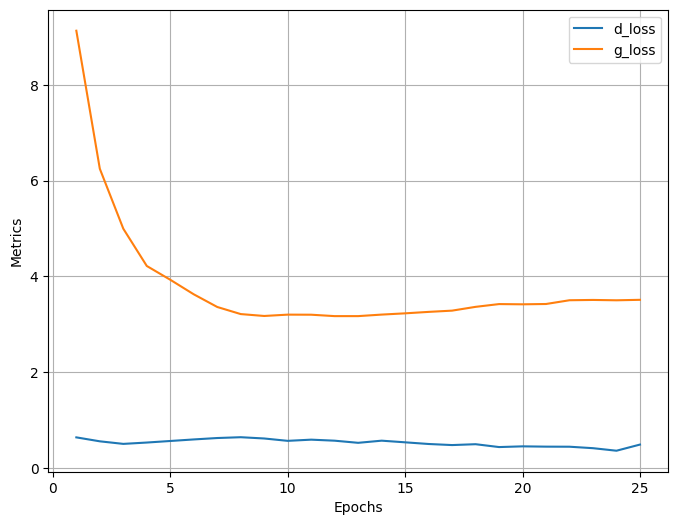

In [20]:
# Train the model
discriminator = Discriminator().to(device)
generator = Generator().to(device)
criterion = nn.BCELoss()
d_optimizer = optim.Adam(discriminator.parameters(), lr=2e-4, betas=(0.5, 0.999))
g_optimizer = optim.Adam(generator.parameters(), lr=2e-4, betas=(0.5, 0.999))
dataloader = load_data()
n_epochs = 25
log = Report(n_epochs)

for epoch in range(n_epochs):
    n = len(dataloader)
    for i, images in enumerate(dataloader):
        # Train the Discriminator
        real_data = images.to(device)
        fake_data = generator(noise(len(real_data))).to(device)
        fake_data = fake_data.detach() # detach tensor so training discriminator does not affect generator
        d_loss = train_discriminator(discriminator, (real_data, fake_data), criterion, d_optimizer)

        # Train the Generator
        fake_data = generator(noise(len(real_data))).to(device) # regenerate fake data
        g_loss = train_generator(discriminator, (real_data, fake_data), criterion, g_optimizer)
        log.record(epoch+(i+1)/n, d_loss=d_loss.item(), g_loss=g_loss.item(), end='\r')
    log.report_avgs(epoch+1)
log.plot_epochs(['d_loss', 'g_loss'])

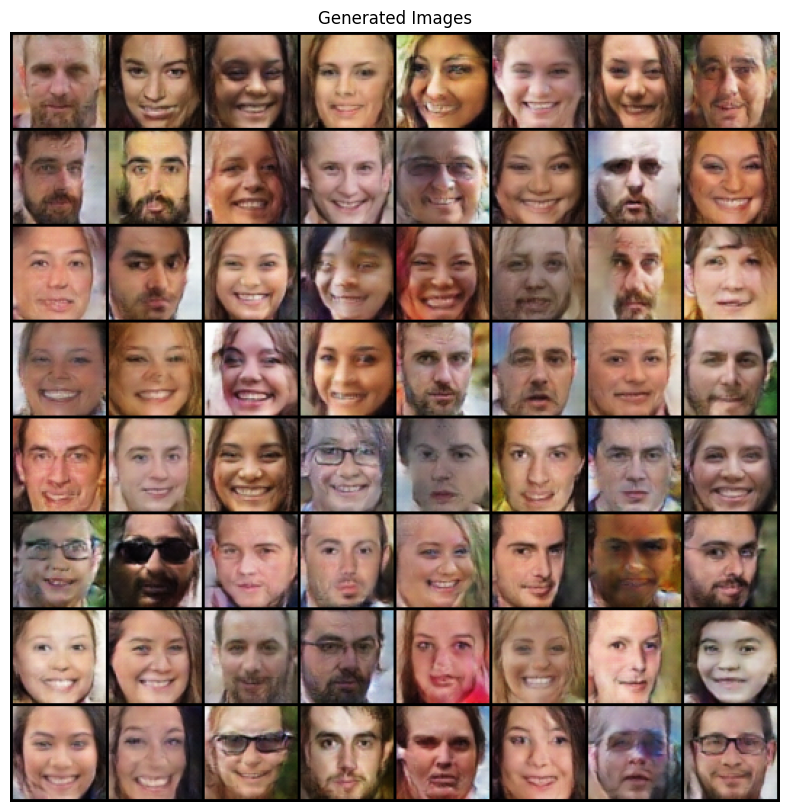

In [23]:
# Plot the generated images
generator.eval()
generated_images = generator(noise(64)).detach().cpu()
grid = make_grid(generated_images, nrow=8, normalize=True)
show(grid.cpu().detach().permute(1, 2, 0), sz=10, title='Generated Images')